# importing required libraries

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU


# loading and preprocessing dataset

In [2]:
def load_data(dataset_dir, target_size=(256, 256)):
    images_dir = os.path.join(dataset_dir, 'normal')
    masks_dir = os.path.join(dataset_dir, 'mask')

    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Images directory not found: {images_dir}")
    if not os.path.exists(masks_dir):
        raise FileNotFoundError(f"Masks directory not found: {masks_dir}")

    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))

    images = []
    masks = []

    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        mask_file = img_file.replace('.png', '_mask.png')
        mask_path = os.path.join(masks_dir, mask_file)

        if not os.path.exists(mask_path):
            print(f"Mask not found for {img_file}. Skipping.")
            continue

        try:
            # Extract numbers from filenames
            img_number = extract_number(img_file)
            mask_number = extract_number(mask_file)

            if img_number is None or mask_number is None or img_number != mask_number:
                print(f"Image and mask numbers do not match for {img_file} and {mask_file}. Skipping.")
                continue

            # Read and resize image and mask
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                print(f"Error loading image {img_file} or mask {mask_file}. Skipping.")
                continue

            img_resized = cv2.resize(img, target_size)
            mask_resized = cv2.resize(mask, target_size)

            images.append(img_resized)
            masks.append(mask_resized)

        except Exception as e:
            print(f"Error processing {img_file} and {mask_file}: {str(e)}")

    # Convert lists to numpy arrays
    images = np.array(images) / 255.0  # Normalize images to [0, 1]
    masks = (np.array(masks) > 0).astype(np.uint8)  # Convert masks to binary (0, 1)

    return images, masks

def extract_number(filename):
    import re
    match = re.search(r'\((\d+)\)', filename)
    if match:
        return int(match.group(1))
    return None

# Specify the dataset directory path
dataset_dir = r'C:\Users\Gambhir\OneDrive\Desktop\Breast-Cancer-Ultrasound-Images-Dataset\Dataset_BUSI_with_GT'

# Load and preprocess dataset
images, masks = load_data(dataset_dir, target_size=(256, 256))


# u-net model

In [3]:

# Define U-Net model for semantic segmentation
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder (contracting path)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder (expansive path)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Define input shape
input_shape = (256, 256, 1)  # Assuming input images are grayscale (single channel)

# Build the model
model = unet_model(input_shape)

# Compile the model
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=60, validation_data=(X_val, y_val))

# Evaluate the model
loss, mean_iou = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Mean IoU: {mean_iou}")



Epoch 1/5



11/11 [==============================] - 2061s 186s/step - loss: 0.5930 - accuracy: 0.8379 - val_loss: 0.3335 - val_accuracy: 0.9225
Epoch 2/5
11/11 [==============================] - 2254s 207s/step - loss: 0.2907 - accuracy: 0.9216 - val_loss: 0.2722 - val_accuracy: 0.9225
Epoch 3/5
11/11 [==============================] - 2821s 254s/step - loss: 0.2686 - accuracy: 0.9216 - val_loss: 0.2572 - val_accuracy: 0.9225
Epoch 4/5
11/11 [==============================] - 2891s 263s/step - loss: 0.2643 - accuracy: 0.9216 - val_loss: 0.2629 - val_accuracy: 0.9225
Epoch 5/5
5/5 [==============================] - 56s 11s/step - loss: 0.2448 - accuracy: 0.9225
Validation Loss: 0.2447705864906311
Mean IoU: 0.9224879145622253


1/1 [==============================] - 0s 405ms/step


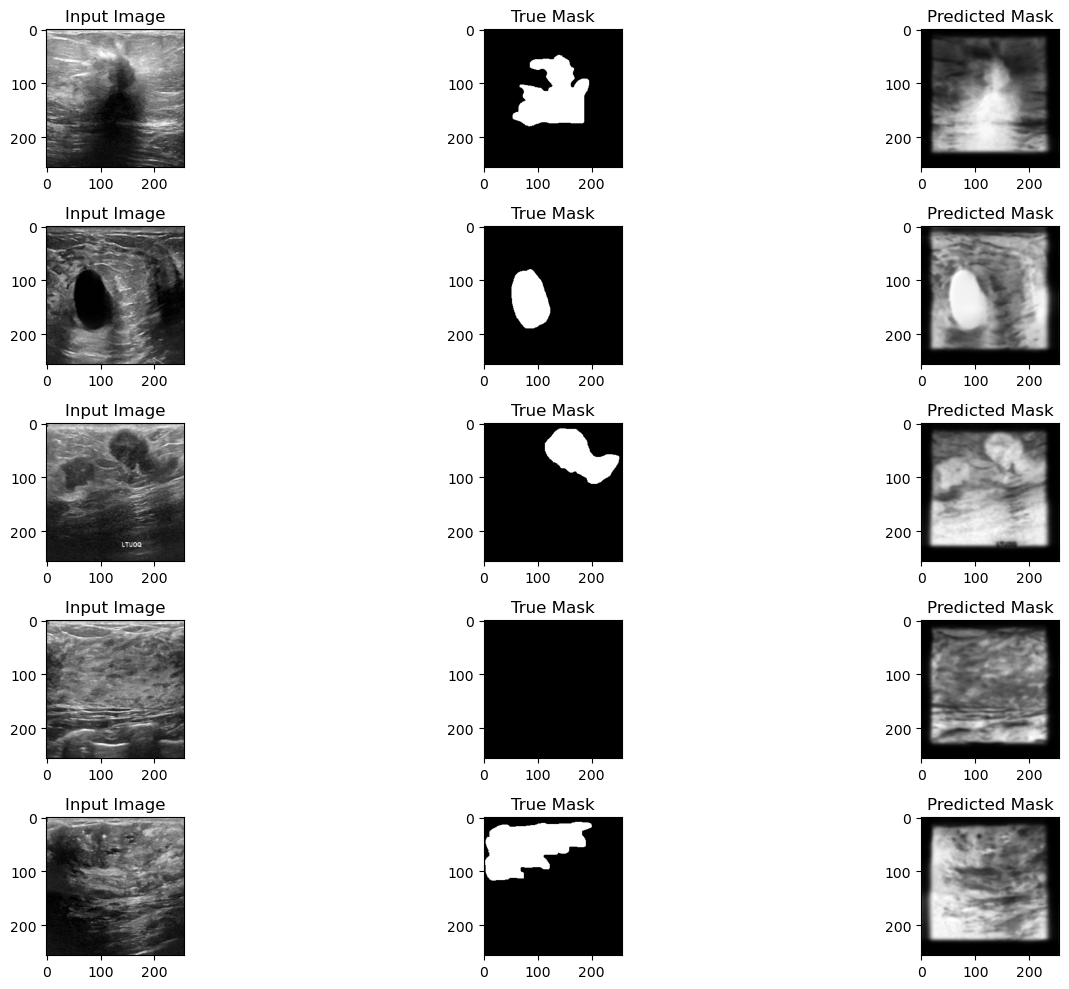

In [4]:
# Visualize predictions
num_samples = 5
sample_indices = np.random.choice(len(X_val), num_samples, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices, 1):
    img = X_val[idx]-----
    true_mask = y_val[idx]
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

    plt.subplot(num_samples, 3, 3 * (i - 1) + 1)
    plt.imshow(img, cmap='gray')
    plt.title("Input Image")

    plt.subplot(num_samples, 3, 3 * (i - 1) + 2)
    plt.imshow(true_mask, cmap='gray')  # Display true mask directly
    plt.title("True Mask")

    plt.subplot(num_samples, 3, 3 * (i - 1) + 3)
    plt.imshow(pred_mask, cmap='gray')  # Display predicted mask directly
    plt.title("Predicted Mask")

plt.tight_layout()
plt.show()


In [5]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def load_data(dataset_dir, target_size=(256, 256)):
    images_dir = os.path.join(dataset_dir, 'normal')
    masks_dir = os.path.join(dataset_dir, 'mask')

    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Images directory not found: {images_dir}")
    if not os.path.exists(masks_dir):
        raise FileNotFoundError(f"Masks directory not found: {masks_dir}")

    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))

    images = []
    masks = []

    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        mask_file = img_file.replace('.png', '_mask.png')
        mask_path = os.path.join(masks_dir, mask_file)

        if not os.path.exists(mask_path):
            print(f"Mask not found for {img_file}. Skipping.")
            continue

        try:
            # Read and resize image and mask
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                print(f"Error loading image {img_file} or mask {mask_file}. Skipping.")
                continue

            img_resized = cv2.resize(img, target_size)
            mask_resized = cv2.resize(mask, target_size)

            images.append(img_resized)
            masks.append(mask_resized)

        except Exception as e:
            print(f"Error processing {img_file} and {mask_file}: {str(e)}")

    # Convert lists to numpy arrays
    images = np.array(images) / 255.0  # Normalize images to [0, 1]
    masks = (np.array(masks) > 0).astype(np.uint8)  # Convert masks to binary (0, 1)

    return images, masks

def preprocess_images(images):
    processed_images = []
    for img in images:
        # Resize image to (256, 256) and normalize pixel values
        img_resized = cv2.resize(img, (256, 256)) / 255.0
        processed_images.append(img_resized)
    return np.array(processed_images)

# Define dataset directory
dataset_dir = r'C:\Users\Gambhir\OneDrive\Desktop\Breast-Cancer-Ultrasound-Images-Dataset\Dataset_BUSI_with_GT'


# VGG16 model

In [6]:

def build_unet(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    encoder = base_model.get_layer('block5_conv3').output
    decoder = Conv2D(512, 3, activation='relu', padding='same')(encoder)
    decoder = Conv2D(512, 3, activation='relu', padding='same')(decoder)
    decoder = UpSampling2D((2, 2))(decoder)
    decoder = concatenate([base_model.get_layer('block4_conv3').output, decoder], axis=-1)
    decoder = Conv2D(256, 3, activation='relu', padding='same')(decoder)
    decoder = Conv2D(256, 3, activation='relu', padding='same')(decoder)
    decoder = UpSampling2D((2, 2))(decoder)
    decoder = concatenate([base_model.get_layer('block3_conv3').output, decoder], axis=-1)
    decoder = Conv2D(128, 3, activation='relu', padding='same')(decoder)
    decoder = Conv2D(128, 3, activation='relu', padding='same')(decoder)
    decoder = UpSampling2D((2, 2))(decoder)
    decoder = concatenate([base_model.get_layer('block2_conv2').output, decoder], axis=-1)
    decoder = Conv2D(64, 3, activation='relu', padding='same')(decoder)
    decoder = Conv2D(64, 3, activation='relu', padding='same')(decoder)

    outputs = Conv2D(num_classes, 1, activation='sigmoid')(decoder)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [7]:
# Load dataset
images, masks = load_data(dataset_dir)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Preprocess images
X_train_preprocessed = preprocess_images(X_train)
X_val_preprocessed = preprocess_images(X_val)

# Resize ground truth masks to match model output dimensions
target_size = (128, 128)  # Update to match model output shape
y_train_resized = [cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST) for mask in y_train]
y_val_resized = [cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST) for mask in y_val]

# Convert resized masks to numpy arrays and add channel dimension
y_train_resized = np.array(y_train_resized)[..., np.newaxis]
y_val_resized = np.array(y_val_resized)[..., np.newaxis]

# Define input shape and number of classes
input_shape = (256, 256, 3)  # Assuming RGB images
num_classes = 1  # Binary segmentation (foreground vs. background)

# Build and compile the model
model = build_unet(input_shape, num_classes)
model.summary()

# Train the model
history = model.fit(X_train_preprocessed, y_train_resized, epochs=5, batch_size=8, validation_data=(X_val_preprocessed, y_val_resized))

# Evaluate the model
loss, accuracy = model.evaluate(X_val_preprocessed, y_val_resized)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

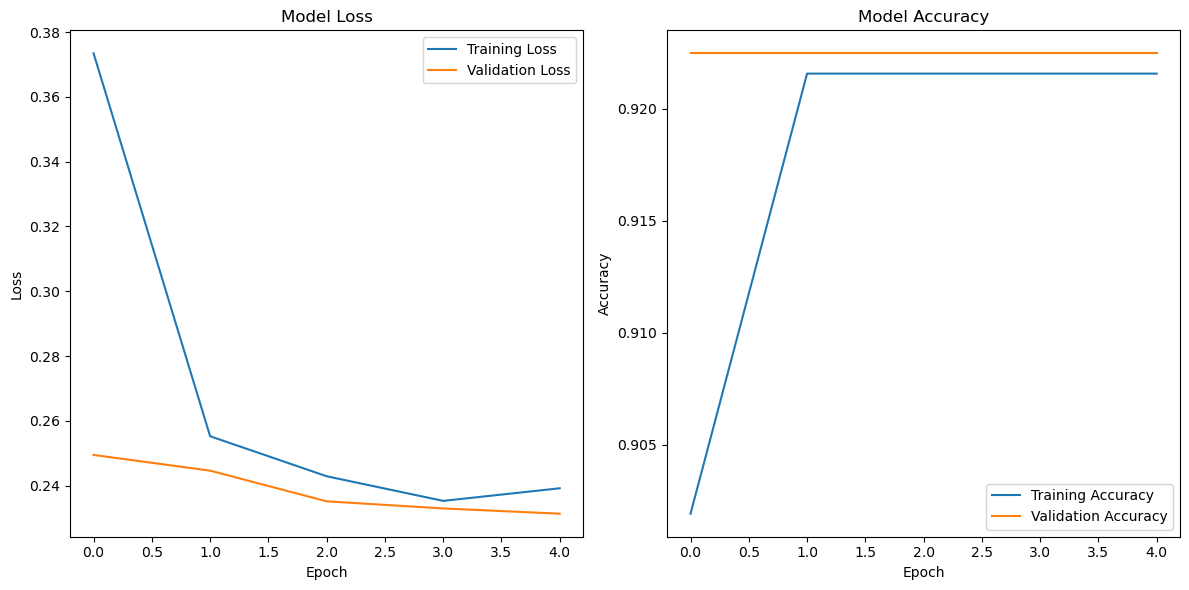

1/1 [==============================] - 1s 615ms/step


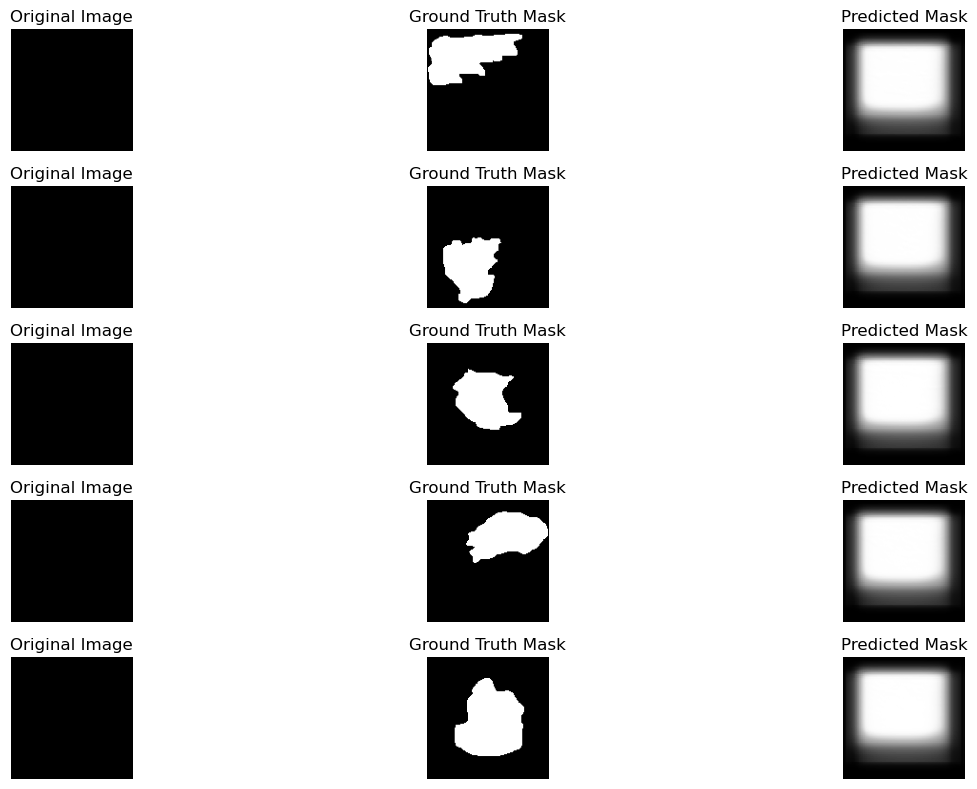

In [10]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Visualize model predictions
def visualize_segmentation(model, images, masks, num_samples=5):
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        # Generate prediction
        pred_mask = model.predict(np.expand_dims(images[i], axis=0))[0]

        # Plot original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize model predictions on validation set
visualize_segmentation(model, X_val_preprocessed, y_val_resized)